In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lion-pytorch
!pip install torcheval
!pip install torchmetrics

In [3]:
import sys
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler, RandomSampler
from pathlib import Path
from torchvision.datasets import ImageFolder
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import matplotlib.pyplot as plt
import random
import collections
import pickle
import torch.nn as nn
from torchvision.models import ResNet18_Weights
import tqdm
from torch import optim
from collections import Counter
import math
import shutil
import torch.nn.functional as F
from torcheval.metrics.functional import multiclass_f1_score
from torchmetrics.classification import MulticlassRecall
import statistics
from tqdm import tqdm
from torchvision.models import resnet34, resnet18
from torchvision.models import ResNet34_Weights,ResNet18_Weights
import torch.optim.lr_scheduler as lr_scheduler
from lion_pytorch import Lion

In [ ]:
! unzip /content/drive/MyDrive/MyShroomClassifier/datasets/Mushrooms_augmented_with_personal.zip

In [11]:
def create_dataset(parent_directory_name):
    classes = os.listdir(parent_directory_name)

    # Preprocess the data:
    # Create the transformation for the pictures for them to be the same size and
    # Convert the picture to a tensor: a n dimensional array
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([224, 224])])
    print("class count numbers")
    for clas in classes:
        print(len(os.listdir(parent_directory_name + clas)))
    # Define the ImageFolder dataset
    # divide root folder in its subfolders and their image content
    dataset = ImageFolder(root=parent_directory_name, transform=transform)

    return dataset

def idx2class(dataset):
    # create a dictionary of the form idx:class_name
    idx2class = {v: k for k, v in dataset.class_to_idx.items()}
    return idx2class


In [12]:
def save_to_file(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_from_file(file_name):
    # Load the classes with their img counts dictionary from the file
    with open(file_name, 'rb') as f:
        obj = pickle.load(f)
    return obj


def calculate_weights(dataset, class_distribution, dataset_name):
    # Calculate the weights of each class
    img_count_per_class = np.fromiter(class_distribution.values(), dtype=float)
    classes = class_distribution.keys()
    # the actual weights of classes
    raw_weights = len(dataset) / (len(classes) * img_count_per_class)

    # normalized weights : the bigger the number the lesser imgs are in that class
    weights = raw_weights / np.sum(raw_weights)

    weights_dict = {}
    for A, B in zip(classes, weights):
        weights_dict[A] = B
    print("weights_dict" + str(weights_dict))
    try:
        save_to_file(weights_dict,
                     f"drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_weights_" + dataset_name
                     + ".pickle")
        return weights_dict
    except Exception as e:  # work on python 3.x
        print('Failed to upload to ftp: ' + str(e))



#get the number of pictures for each class
#return a dictionary of form class:nr_of_elements
def get_class_distribution(dataset, dataset_name):
    # Determine count of images per class in training_dataset
    # Collect the labels in a list or dictionary

    class_counts = dict(Counter(dataset.targets))
    print("class_counts" + str(class_counts))
    myKeys = list(class_counts.keys())
    myKeys.sort()
    sorted_class_counts = {i: class_counts[i] for i in myKeys}

    save_to_file(sorted_class_counts, "drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_img_count_" + dataset_name + ".pickle")



def save_to_folders(train_dataset, val_dataset, test_dataset, classes, dir_name):
    if (not os.path.isdir(dir_name + "/test/Suillus")):
      output_folders = ['train', 'val', 'test']
      output_dirs = {
          output_folders[0]: dir_name + '/train',
          output_folders[1]:  dir_name + '/val',
          output_folders[2]: dir_name + '/test'
      }

      # Create the output directories if they don't exist
      for output_dir in output_dirs.values():
          Path(output_dir).mkdir(parents=True, exist_ok=True)
          for class_name in classes:
              Path(output_dir + "/" + class_name).mkdir(parents=True, exist_ok=True)
      subsets = [train_dataset, val_dataset, test_dataset]
      for i in range(len(subsets)):
          subset = subsets[i]
          for j in range(len(subset)):
              img_tensor = subset[j][0]
              label = subset[j][1]
              to_img_transform = transforms.ToPILImage()
              img = to_img_transform(img_tensor)
              img_name = "/" + str(j) + ".jpg"

              img.save(dir_name + "/" + output_folders[i] + "/" + classes[label] + img_name)



In [13]:
# Define your subset as a PyTorch Dataset object
class MySubset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        # Return a single (tensor, label) tuple
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [14]:
import statistics
def split_train_val_test(dataset):

    classes = os.listdir("Mushrooms_augmented_Mircea")

    idx2_class = idx2class(dataset)

    # Split dataset into train, validation, and test sets
    train_size = int(len(dataset) * 0.75)  # 75% train
    val_size = int(len(dataset) * 0.15)  # 15% val
    test_size = len(dataset) - train_size - val_size  # 10% test
    print("train:", train_size, "\nval:", val_size, "\ntest:", test_size)

    # Use the random_split function to split the dataset
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

    # Save the distribution of the newly split dataset
    get_class_distribution(train_dataset, "train_personal")
    return train_dataset, val_dataset, test_dataset




## **Augment1 experiment**:


- Augment every minority class(that has a difference of 100 or more to the avg_class_count) image so that class_count := class_count + class_count * avg_class_count/ class_count
- Decrement the number of images from the classes that have a (avg_class_count + 100)+ class count so that class_count := avg_class_count + 100



In [ ]:


def split_train_val_test_augment1(dataset, input_dir, output_dir):

  # Use the random_split function to split the dataset
  if not os.path.isdir(output_dir + "/train/Agaricus"):
    train_dataset, val_dataset, test_dataset = split_train_val_test(dataset)
    classes = os.listdir(input_dir)

    transform_list = [
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.RandomPerspective(distortion_scale=0.4, p=1.0),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=30),

    ]

    # Create a list of augmented images and labels
    augmented_images = []
    augmented_labels = []
    if(not os.path.isfile(r"drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_img_count_train_personal.pickle")):
        get_class_distribution(train_dataset, "train")
    class_counts = load_from_file("drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_img_count_train__personal.pickle")
    print(class_counts)
    print(classes)
    avg_class_count = statistics.mean(class_counts.values())
    current_data = [train_dataset.__getitem__(i) for i in range(len(train_dataset))]

    # Augment images with random transform based on the "class weight" --> count
    for label_idx in range(len(classes)):

        class_count = class_counts[label_idx]
        if avg_class_count - class_count > 100:
            # Augment only classes that are below average of all class counts
            # Determine the number of transformations to apply
            # optimal value must be found
            num_augmentations = class_count * avg_class_count / class_count - class_count

            # Get the indices of the images in this class
            indices = []
            for i in range(len(current_data)):
                if current_data[i][1] == label_idx:
                    indices.append(i)
            # print(num_augmentations)
            for augment in range(math.ceil(num_augmentations)):
                # Select a random image from this class
                img_idx = random.randrange(0, len(indices))
                t = transforms.ToPILImage()
                img = current_data[indices[img_idx]][0]
                img = t(current_data[indices[img_idx]][0])

                # Apply a random transformation
                transform_idx = random.randrange(0, len(transform_list))
                transform = transform_list[transform_idx]

                img = transform(img)
                to_tensor = transforms.ToTensor()
                img = to_tensor(img)
                # Add the transformed image and label to the list
                augmented_images.append(img)
                augmented_labels.append(label_idx)


        else:
            if class_count - avg_class_count > 100:
                # Get the indices of the images in this class
                indices = []
                for i in range(len(current_data)):
                    if current_data[i][1] == label_idx:
                        indices.append(i)

                while class_count >= avg_class_count:
                    img_idx = random.randrange(0, len(indices))

                    current_data.pop(indices[img_idx])
                    class_count -= 1
                    # Make sure that the other indices change after deleting
                    # Starting from the index from indices where the index(current_data) was saved + 1
                    for indices_idx in range(img_idx + 1, len(indices)):
                        indices[indices_idx] -= 1
                    indices.pop(img_idx)
    # # get the current tensor and label data from the train_subset

    new_data = [(augmented_images[i], augmented_labels[i]) for i in range(len(augmented_images))]
    updated_data = current_data + new_data
    train_dataset = MySubset(updated_data)
    save_to_folders(train_dataset, val_dataset, test_dataset, classes, output_dir)


  else:
    print("Data folder already exists...You're ready to GO")


## **Augment2 experiment**:
- Augment every minority class(that has a difference of 50 or more to the avg_class_count) image so that class_count := class_count + class_count * avg_class_count/ class_count
- Decrement the number of images from the classes that have a (avg_class_count + 100)+ class count so that class_count := avg_class_count + 100

In [15]:
def split_train_val_test_augment2(dataset, output_dir):

    # Use the random_split function to split the dataset
  if not os.path.isdir("drive/MyDrive/MyShroomClassifier/" + output_dir + "/train/Agaricus"):
    train_dataset, val_dataset, test_dataset = split_train_val_test(dataset)
    classes = os.listdir("Mushrooms_augmented_Mircea")

    transform_list = [
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.RandomPerspective(distortion_scale=0.4, p=1.0),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=30),

    ]

    # Create a list of augmented images and labels
    augmented_images = []
    augmented_labels = []
    if(not os.path.isfile(r"drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_img_count_personal_train.pickle")):
        get_class_distribution(train_dataset, "train")
    class_counts = load_from_file("drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_img_count_personal_train.pickle")
    print(class_counts)
    print(classes)
    avg_class_count = statistics.mean(class_counts.values())
    current_data = [train_dataset.__getitem__(i) for i in range(len(train_dataset))]

    # Augment images with random transform based on the "class weight" --> count
    for label_idx in range(len(classes)):

        class_count = class_counts[label_idx]

          # Augment only classes that are below average of all class counts
        if avg_class_count - class_count > 50:

          # Determine the number of transformations to apply
          # optimal value must be found
          num_augmentations = class_count * avg_class_count / class_count
          # Get the indices of the images in this class
          indices = []
          for i in range(len(current_data)):
              if current_data[i][1] == label_idx:
                  indices.append(i)
          # print(num_augmentations)
          for augment in range(math.ceil(num_augmentations)):
              # Select a random image from this class
              img_idx = random.randrange(0, len(indices))
              t = transforms.ToPILImage()
              img = current_data[indices[img_idx]][0]
              img = t(current_data[indices[img_idx]][0])

              # Apply a random transformation
              transform_idx = random.randrange(0, len(transform_list))
              transform = transform_list[transform_idx]

              img = transform(img)
              to_tensor = transforms.ToTensor()
              img = to_tensor(img)
              # Add the transformed image and label to the list
              augmented_images.append(img)
              augmented_labels.append(label_idx)


        else:
            if class_count - avg_class_count > 100:
                # Get the indices of the images in this class
                indices = []
                for i in range(len(current_data)):
                    if current_data[i][1] == label_idx:
                        indices.append(i)

                while class_count >= avg_class_count + 100:
                    img_idx = random.randrange(0, len(indices))

                    current_data.pop(indices[img_idx])
                    class_count -= 1
                    # Make sure that the other indices change after deleting
                    # Starting from the index from indices where the index(current_data) was saved + 1
                    for indices_idx in range(img_idx + 1, len(indices)):
                        indices[indices_idx] -= 1
                    indices.pop(img_idx)
    # # get the current tensor and label data from the train_subset

    new_data = [(augmented_images[i], augmented_labels[i]) for i in range(len(augmented_images))]
    updated_data = current_data + new_data
    train_dataset = MySubset(updated_data)
    save_to_folders(train_dataset, val_dataset, test_dataset, classes, output_dir)


  else:
      print("Data folder already exists...You're ready to GO")



## **Augment3 experiment**:
- Augment every minority class(that has a difference of 50 or more to the avg_class_count) image so that class_count := class_count + class_count * avg_class_count/ class_count
- No decrementation of majority classes


In [16]:

def split_train_val_test_augment3(dataset, output_dir, class_distribution_file_name):

    # Use the random_split function to split the dataset
  if not os.path.isdir(output_dir + "/train/Agaricus"):
    train_dataset, val_dataset, test_dataset = split_train_val_test(dataset)
    classes = os.listdir("Mushrooms_augmented_Mircea")

    transform_list = [
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.RandomPerspective(distortion_scale=0.4, p=1.0),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=30),

    ]

    # Create a list of augmented images and labels
    augmented_images = []
    augmented_labels = []
    if(not os.path.isfile(r"drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_img_count_personal_train.pickle")):
        get_class_distribution(train_dataset, "train")
    class_counts = load_from_file("drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_img_count_personal_train.pickle")
    print(class_counts)
    print(classes)
    avg_class_count = statistics.mean(class_counts.values())
    current_data = [train_dataset.__getitem__(i) for i in range(len(train_dataset))]

    # Augment images with random transform based on the "class weight" --> count
    for label_idx in range(len(classes)):

        class_count = class_counts[label_idx]

          # Augment only classes that are below average of all class counts
        if avg_class_count - class_count > 50:

          # Determine the number of transformations to apply
          # optimal value must be found
          num_augmentations = class_count * avg_class_count / class_count
          # Get the indices of the images in this class
          indices = []
          for i in range(len(current_data)):
              if current_data[i][1] == label_idx:
                  indices.append(i)
          # print(num_augmentations)
          for augment in range(math.ceil(num_augmentations)):
              # Select a random image from this class
              img_idx = random.randrange(0, len(indices))
              t = transforms.ToPILImage()
              img = current_data[indices[img_idx]][0]
              img = t(current_data[indices[img_idx]][0])

              # Apply a random transformation
              transform_idx = random.randrange(0, len(transform_list))
              transform = transform_list[transform_idx]

              img = transform(img)
              to_tensor = transforms.ToTensor()
              img = to_tensor(img)
              # Add the transformed image and label to the list
              augmented_images.append(img)
              augmented_labels.append(label_idx)


    # # get the current tensor and label data from the train_subset

    new_data = [(augmented_images[i], augmented_labels[i]) for i in range(len(augmented_images))]
    updated_data = current_data + new_data
    train_dataset = MySubset(updated_data)
    save_to_folders(train_dataset, val_dataset, test_dataset, classes, output_dir)
    get_class_distribution(train_dataset, "train_" + class_distribution_file_name)
  else:
      print("Data folder already exists...You're ready to GO")


## **Augment4 experiment**:
- Augment all the minority classes so that their image count matches the one of the majority class

In [17]:


# Generate a dataset that has all classes with the same number of images that is -100 of the class[max(nr_of_images)]
def split_train_val_test_augment4(dataset, output_dir, class_distribution_file_name):
    # Use the random_split function to split the dataset
    if not os.path.isdir(output_dir + "/train/Agaricus"):

        train_dataset, val_dataset, test_dataset = split_train_val_test(dataset)
        classes = os.listdir("Mushrooms_augmented_Mircea")

        transform_list = [
            transforms.RandomHorizontalFlip(),
            transforms.Grayscale(),
            transforms.RandomPerspective(distortion_scale=0.4, p=1.0),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=30),

        ]

        if (not os.path.isfile("drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_img_count_personal_train.pickle")):
            get_class_distribution(train_dataset, "train_personal")
        class_counts = load_from_file("drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_img_count_personal_train.pickle")
        print(class_counts)
        print("generated class counts for the training dataset raw")
        max_class_count = max(class_counts.values())

        # Split the dataset into 2 batches
        classes_indexes = [i for i in range(len(classes))]
        classes_first_half = [i for i in range(len(classes_indexes) // 2)]
        classes_second_half = [i for i in range(len(classes_indexes) // 2, len(classes_indexes))]

        current_data1 = [train_dataset.__getitem__(i) for i in range(len(train_dataset)) if
                         train_dataset.__getitem__(i)[1] in classes_first_half]


        current_data2 = [train_dataset.__getitem__(i) for i in range(len(train_dataset)) if
                         train_dataset.__getitem__(i)[1] in classes_second_half]

        # Augment images with random transform based on the "class weight" --> count
        new_data1 = generate_data(current_data1, class_counts, classes_first_half, transform_list, max_class_count)
        new_data2 = generate_data(current_data2, class_counts, classes_second_half, transform_list, max_class_count)
        updated_data = current_data1 + current_data2 + new_data1 + new_data2
        train_dataset = MySubset(updated_data)
        save_to_folders(train_dataset, val_dataset, test_dataset, classes, output_dir)
        get_class_distribution(train_dataset, "train_" + class_distribution_file_name)
    else:
        print("Data folder already exists...You're ready to GO")


def generate_data(data, class_counts, classes, transform_list, max_class_count):
    # Create a list of augmented images and labels
    augmented_data = []
    for label_idx in classes:

        class_count = class_counts[label_idx]

        # Augment only classes that are below average of all class counts
        if class_count < max_class_count:

            # Determine the number of transformations to apply
            # optimal value must be found
            num_augmentations = max_class_count - class_count
            # Get the indices of the images in this class
            indices = []
            for i in range(len(data)):
                if data[i][1] == label_idx:
                    indices.append(i)
            print(len(indices))
            # print(num_augmentations)
            for augment in range(num_augmentations):
                # Select a random image from this class
                img_idx = random.randrange(0, len(indices))
                t = transforms.ToPILImage()
                img = t(data[indices[img_idx]][0])

                # Apply a random transformation
                transform_idx = random.randrange(0, len(transform_list))
                transform = transform_list[transform_idx]

                img = transform(img)
                to_tensor = transforms.ToTensor()
                img = to_tensor(img)
                # Add the transformed image and label to the list
                augmented_data.append((img, label_idx))

    return augmented_data


In [18]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [19]:
import torch.nn.init as init
def init_weights(m):
   if isinstance(m, nn.Conv2d):
      init.normal_(m.weight, mean=0, std=0.01)
      if m.bias is not None:
          init.constant_(m.bias, 0)
   elif isinstance(m, nn.BatchNorm2d):
     init.constant_(m.weight, 1)
     init.constant_(m.bias, 0)
   elif isinstance(m, nn.Linear):
     init.normal_(m.weight, mean=0, std=0.01)
     if m.bias is not None:
      init.constant_(m.bias, 0)

In [44]:
def prepare_model(device, train_dataset_weights=[]):
    model = models.resnet34(weights=ResNet34_Weights.DEFAULT)
    # model.apply(init_weights)
    #maybe overfitting comes from not freezing the layers
    for param in model.parameters():
        param.requires_grad = True

    num_ftrs = model.fc.in_features
    print(model.fc)
    model.fc = nn.Sequential( nn.Linear(out_features=9,in_features=num_ftrs), # 9 is the number of classes in your mushroom image dataset
                             nn.ReLU(), nn.Dropout(p=0.5),

    )
    print(model.fc)

    model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(train_dataset_weights.values()), dtype=torch.float32))
    criterion.to(device)
    # optimizer = optim.Adagrad(model.fc.parameters(), lr=0.001, weight_decay=0.01)
    # optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay = 0.001)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
    # optimizer = Lion(model.parameters(), lr=0.00001, weight_decay=1e-2)
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    return model, criterion, scheduler, optimizer



In [36]:
def train_model(model, train_loader, val_loader, criterion,scheduler,optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    print("is on cuda:", next(model.parameters()).is_cuda)

    early_stopping = EarlyStopping(patience=5, verbose=True)
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_total = 0
        val_total = 0
        train_correct = 0
        val_correct = 0

        model.train()

        loop = tqdm(enumerate(train_loader), total=len(train_loader))

        for i, (inputs, labels) in loop:

          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          train_loss += loss.item() * inputs.size(0)
          train_total += inputs.size(0)
          _, predicted = torch.max(outputs.data, 1)
          train_correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / train_total)
        train_accs.append(train_correct / train_total)

        model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_total += inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

            val_losses.append(val_loss / val_total)
            val_accs.append(val_correct / val_total)

        loop.write(
            f'Epoch {epoch + 1} - Train Loss: {train_losses[-1]:.4f} - Train Acc: {train_accs[-1]:.4f} - Val Loss: '
            f'{val_losses[-1]:.4f} - Val Acc: {val_accs[-1]:.4f} - learning rate: {optimizer.param_groups[0]["lr"]}')
        # Update the learning rate
        scheduler.step(val_loss)
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        # if (abs(val_loss-train_loss) > 0.15 and epoch > 18):
        #   print("!overfitting of under fitting!")
        #   break

    return train_losses, val_losses, train_accs, val_accs


In [23]:
from torchvision import transforms
import shutil

dataset=create_dataset("Mushrooms_augmented_with_personal/")
target_dir = "/content/drive/MyDrive/MyShroomClassifier/augmented_datasets/Mushrooms_output_augment4_personal.zip"
print(os.listdir("/content/drive/MyDrive/MyShroomClassifier/augmented_datasets/"))
if not os.path.exists(target_dir):
  classes = os.listdir("Mushrooms_augmented_with_personal/")
  split_train_val_test_augment1(dataset, "Mushrooms_augmented_with_personal", "Mushrooms_output_augment4_personal")



FileNotFoundError: ignored

In [26]:
!unzip /content/drive/MyDrive/MyShroomClassifier/augmented_datasets/Mushrooms_output_augment4_personal.zip
# !unzip /content/drive/MyDrive/MyShroomClassifier/augmented_datasets/Mushrooms_output_train60_augment4_inception_personal.zip


In [27]:
from torchvision import transforms

transforms = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_dataset = datasets.ImageFolder("Mushrooms_output_augment4_personal/train", transform=transforms)
val_dataset = datasets.ImageFolder("Mushrooms_output_augment4_personal/val", transform=transforms)
test_dataset = datasets.ImageFolder("Mushrooms_output_augment4_personal/test", transform=transforms)


# Calculate the weights for each class(raw_weights) and the normalized version of it(train_dataset_weights
# Create dictionary with class label as keys and class_weight as values
train_dataset_distribution =load_from_file("/content/drive/MyDrive/MyShroomClassifier/util_files/classes_with_their_img_count_train_augment4_personal.pickle")
train_dataset_normalized_weights = calculate_weights(train_dataset, train_dataset_distribution, "augment4_personal")
print(train_dataset_distribution)
sample_weights = torch.Tensor([train_dataset_normalized_weights[label] for label in train_dataset.targets])



batch_size = 128
# You don't need shuffle bc the dataset that was split was already shuffled
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


weights_dict{0: 0.1111111111111111, 1: 0.1111111111111111, 2: 0.1111111111111111, 3: 0.1111111111111111, 4: 0.1111111111111111, 5: 0.1111111111111111, 6: 0.1111111111111111, 7: 0.1111111111111111, 8: 0.1111111111111111}
{0: 1173, 1: 1173, 2: 1173, 3: 1173, 4: 1173, 5: 1173, 6: 1173, 7: 1173, 8: 1173}


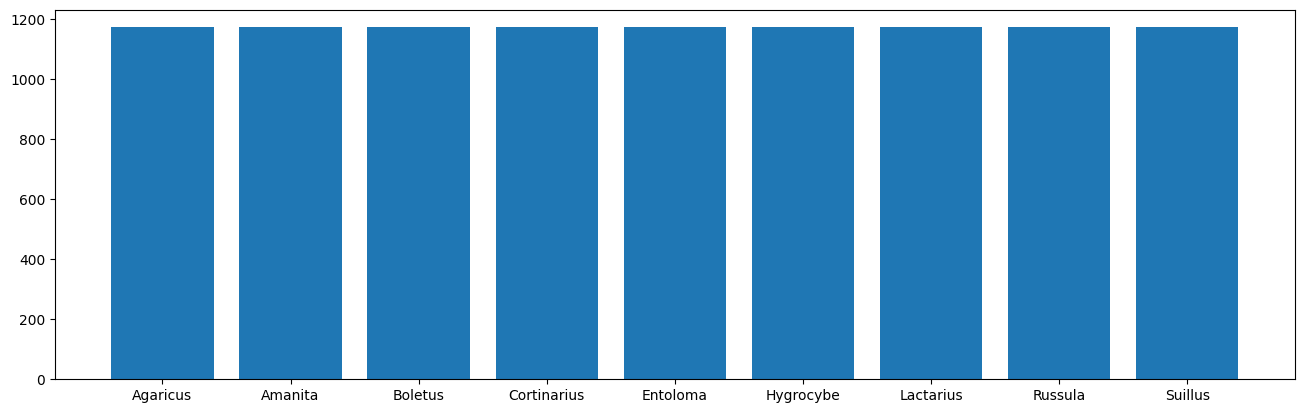

In [28]:
import matplotlib.pyplot as plt

def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}

    idx2class = {v: k for k, v in dataset_obj.class_to_idx.items()}
    for _,j in dataloader_obj:

      y_indexes = j.data

      for y_index in y_indexes:
        y_lbl = idx2class[y_index.item()]
        count_dict[str(y_lbl)] += 1

    return count_dict

class_distr_val = get_class_distribution_loaders(val_loader, val_dataset)
class_distr_train = get_class_distribution_loaders(train_loader, train_dataset)


names_train = list(class_distr_train.keys())

values_train = class_distr_train.values()
values_val = class_distr_val.values()

#train_dataset distribution after augmentation
plt.figure().set_figwidth(16)
plt.bar(range(len(class_distr_val)), values_train, tick_label=names_train)
plt.show()



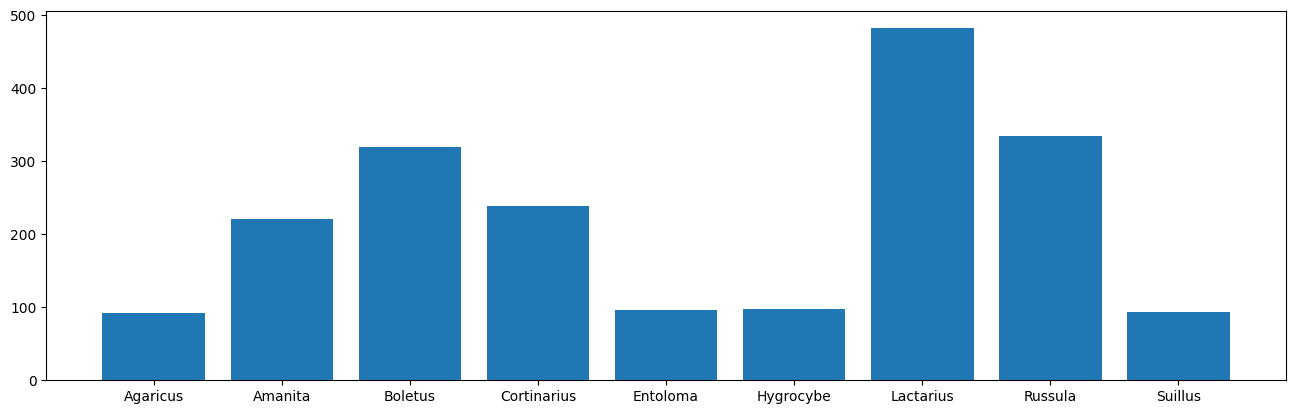

In [ ]:
#validation data_set distribution
plt.figure().set_figwidth(16)
plt.bar(range(len(class_distr_val)), values_val, tick_label=names_train)
plt.show()


In [29]:
print(len(train_dataset))

10557


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, criterion,scheduler, optimizer = prepare_model(device, train_dataset_normalized_weights)
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, scheduler, optimizer, 50, device)
print("MAX VALIDATION ACCURACY:",max(val_accs))


Linear(in_features=512, out_features=1000, bias=True)
Sequential(
  (0): Linear(in_features=512, out_features=9, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
)
is on cuda: True


100%|██████████| 83/83 [00:42<00:00,  1.93it/s]


Epoch 1 - Train Loss: 2.1634 - Train Acc: 0.1592 - Val Loss: 1.9344 - Val Acc: 0.3600 - learning rate: 0.001
Validation loss decreased (inf --> 1907.335903).  Saving model ...


100%|██████████| 83/83 [00:42<00:00,  1.93it/s]


Epoch 2 - Train Loss: 2.0284 - Train Acc: 0.2236 - Val Loss: 1.8081 - Val Acc: 0.4047 - learning rate: 0.001
Validation loss decreased (1907.335903 --> 1782.800569).  Saving model ...


100%|██████████| 83/83 [00:42<00:00,  1.97it/s]


Epoch 3 - Train Loss: 1.9456 - Train Acc: 0.2561 - Val Loss: 1.7225 - Val Acc: 0.4361 - learning rate: 0.001
Validation loss decreased (1782.800569 --> 1698.337748).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  1.98it/s]


Epoch 4 - Train Loss: 1.8908 - Train Acc: 0.2717 - Val Loss: 1.6595 - Val Acc: 0.4473 - learning rate: 0.001
Validation loss decreased (1698.337748 --> 1636.274345).  Saving model ...


100%|██████████| 83/83 [00:42<00:00,  1.97it/s]


Epoch 5 - Train Loss: 1.8704 - Train Acc: 0.2753 - Val Loss: 1.6299 - Val Acc: 0.4594 - learning rate: 0.001
Validation loss decreased (1636.274345 --> 1607.102926).  Saving model ...


100%|██████████| 83/83 [00:42<00:00,  1.96it/s]


Epoch 6 - Train Loss: 1.8308 - Train Acc: 0.2875 - Val Loss: 1.6066 - Val Acc: 0.4675 - learning rate: 0.001
Validation loss decreased (1607.102926 --> 1584.064079).  Saving model ...


100%|██████████| 83/83 [00:42<00:00,  1.97it/s]


Epoch 7 - Train Loss: 1.8087 - Train Acc: 0.2953 - Val Loss: 1.5795 - Val Acc: 0.4706 - learning rate: 0.001
Validation loss decreased (1584.064079 --> 1557.342100).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  1.99it/s]


Epoch 8 - Train Loss: 1.7872 - Train Acc: 0.3018 - Val Loss: 1.5531 - Val Acc: 0.4726 - learning rate: 0.001
Validation loss decreased (1557.342100 --> 1531.314993).  Saving model ...


100%|██████████| 83/83 [00:43<00:00,  1.93it/s]


Epoch 9 - Train Loss: 1.7726 - Train Acc: 0.3074 - Val Loss: 1.5357 - Val Acc: 0.4706 - learning rate: 0.001
Validation loss decreased (1531.314993 --> 1514.172735).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  1.98it/s]


Epoch 10 - Train Loss: 1.7642 - Train Acc: 0.3084 - Val Loss: 1.5219 - Val Acc: 0.4686 - learning rate: 0.001
Validation loss decreased (1514.172735 --> 1500.576448).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  1.98it/s]


Epoch 11 - Train Loss: 1.7459 - Train Acc: 0.3128 - Val Loss: 1.5220 - Val Acc: 0.4726 - learning rate: 0.001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.00it/s]


Epoch 12 - Train Loss: 1.6958 - Train Acc: 0.3170 - Val Loss: 1.4996 - Val Acc: 0.4828 - learning rate: 0.001
Validation loss decreased (1500.576448 --> 1478.574371).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 13 - Train Loss: 1.6814 - Train Acc: 0.3153 - Val Loss: 1.4680 - Val Acc: 0.4848 - learning rate: 0.001
Validation loss decreased (1478.574371 --> 1447.423680).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 14 - Train Loss: 1.6635 - Train Acc: 0.3167 - Val Loss: 1.4691 - Val Acc: 0.4878 - learning rate: 0.001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:43<00:00,  1.93it/s]


Epoch 15 - Train Loss: 1.6523 - Train Acc: 0.3187 - Val Loss: 1.4641 - Val Acc: 0.4858 - learning rate: 0.001
Validation loss decreased (1447.423680 --> 1443.620843).  Saving model ...


100%|██████████| 83/83 [00:42<00:00,  1.98it/s]


Epoch 16 - Train Loss: 1.6425 - Train Acc: 0.3200 - Val Loss: 1.4478 - Val Acc: 0.4858 - learning rate: 0.001
Validation loss decreased (1443.620843 --> 1427.537427).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.00it/s]


Epoch 17 - Train Loss: 1.6425 - Train Acc: 0.3157 - Val Loss: 1.4526 - Val Acc: 0.4878 - learning rate: 0.001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.00it/s]


Epoch 18 - Train Loss: 1.6325 - Train Acc: 0.3199 - Val Loss: 1.4538 - Val Acc: 0.4878 - learning rate: 0.001
EarlyStopping counter: 2 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.00it/s]


Epoch 19 - Train Loss: 1.6220 - Train Acc: 0.3199 - Val Loss: 1.4434 - Val Acc: 0.4899 - learning rate: 0.001
Validation loss decreased (1427.537427 --> 1423.188277).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.00it/s]


Epoch 20 - Train Loss: 1.6147 - Train Acc: 0.3281 - Val Loss: 1.4345 - Val Acc: 0.4949 - learning rate: 0.001
Validation loss decreased (1423.188277 --> 1414.444518).  Saving model ...


100%|██████████| 83/83 [00:42<00:00,  1.95it/s]


Epoch 21 - Train Loss: 1.6233 - Train Acc: 0.3235 - Val Loss: 1.4359 - Val Acc: 0.4919 - learning rate: 0.001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 22 - Train Loss: 1.5796 - Train Acc: 0.3539 - Val Loss: 1.3482 - Val Acc: 0.5609 - learning rate: 0.001
Validation loss decreased (1414.444518 --> 1329.345102).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 23 - Train Loss: 1.5311 - Train Acc: 0.3677 - Val Loss: 1.3190 - Val Acc: 0.5649 - learning rate: 0.001
Validation loss decreased (1329.345102 --> 1300.521951).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.00it/s]


Epoch 24 - Train Loss: 1.5177 - Train Acc: 0.3722 - Val Loss: 1.2984 - Val Acc: 0.5669 - learning rate: 0.001
Validation loss decreased (1300.521951 --> 1280.173596).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 25 - Train Loss: 1.5053 - Train Acc: 0.3733 - Val Loss: 1.2840 - Val Acc: 0.5680 - learning rate: 0.001
Validation loss decreased (1280.173596 --> 1266.017641).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.02it/s]


Epoch 26 - Train Loss: 1.4912 - Train Acc: 0.3796 - Val Loss: 1.3002 - Val Acc: 0.5629 - learning rate: 0.001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 27 - Train Loss: 1.5027 - Train Acc: 0.3764 - Val Loss: 1.2899 - Val Acc: 0.5680 - learning rate: 0.001
EarlyStopping counter: 2 out of 5


100%|██████████| 83/83 [00:42<00:00,  1.95it/s]


Epoch 28 - Train Loss: 1.4950 - Train Acc: 0.3796 - Val Loss: 1.2870 - Val Acc: 0.5629 - learning rate: 0.001
EarlyStopping counter: 3 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 29 - Train Loss: 1.4903 - Train Acc: 0.3782 - Val Loss: 1.2771 - Val Acc: 0.5629 - learning rate: 0.0001
Validation loss decreased (1266.017641 --> 1259.250298).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 30 - Train Loss: 1.4914 - Train Acc: 0.3762 - Val Loss: 1.2797 - Val Acc: 0.5649 - learning rate: 0.0001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 31 - Train Loss: 1.4921 - Train Acc: 0.3791 - Val Loss: 1.2722 - Val Acc: 0.5629 - learning rate: 0.0001
Validation loss decreased (1259.250298 --> 1254.421064).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 32 - Train Loss: 1.5105 - Train Acc: 0.3702 - Val Loss: 1.2737 - Val Acc: 0.5619 - learning rate: 0.0001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 33 - Train Loss: 1.5013 - Train Acc: 0.3732 - Val Loss: 1.2714 - Val Acc: 0.5629 - learning rate: 0.0001
Validation loss decreased (1254.421064 --> 1253.559773).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  1.99it/s]


Epoch 34 - Train Loss: 1.4860 - Train Acc: 0.3815 - Val Loss: 1.2717 - Val Acc: 0.5700 - learning rate: 0.0001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.02it/s]


Epoch 35 - Train Loss: 1.4950 - Train Acc: 0.3751 - Val Loss: 1.2773 - Val Acc: 0.5680 - learning rate: 0.0001
EarlyStopping counter: 2 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 36 - Train Loss: 1.5040 - Train Acc: 0.3722 - Val Loss: 1.2702 - Val Acc: 0.5659 - learning rate: 0.0001
Validation loss decreased (1253.559773 --> 1252.399925).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.02it/s]


Epoch 37 - Train Loss: 1.4893 - Train Acc: 0.3786 - Val Loss: 1.2746 - Val Acc: 0.5629 - learning rate: 0.0001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.02it/s]


Epoch 38 - Train Loss: 1.4785 - Train Acc: 0.3815 - Val Loss: 1.2727 - Val Acc: 0.5649 - learning rate: 0.0001
EarlyStopping counter: 2 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.02it/s]


Epoch 39 - Train Loss: 1.5001 - Train Acc: 0.3767 - Val Loss: 1.2693 - Val Acc: 0.5639 - learning rate: 0.0001
Validation loss decreased (1252.399925 --> 1251.577604).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  1.99it/s]


Epoch 40 - Train Loss: 1.4972 - Train Acc: 0.3757 - Val Loss: 1.2709 - Val Acc: 0.5659 - learning rate: 0.0001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 41 - Train Loss: 1.4889 - Train Acc: 0.3817 - Val Loss: 1.2683 - Val Acc: 0.5720 - learning rate: 0.0001
Validation loss decreased (1251.577604 --> 1250.536487).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.01it/s]


Epoch 42 - Train Loss: 1.4893 - Train Acc: 0.3806 - Val Loss: 1.2716 - Val Acc: 0.5649 - learning rate: 0.0001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:41<00:00,  2.02it/s]


Epoch 43 - Train Loss: 1.4947 - Train Acc: 0.3769 - Val Loss: 1.2606 - Val Acc: 0.5700 - learning rate: 0.0001
Validation loss decreased (1250.536487 --> 1242.921688).  Saving model ...


100%|██████████| 83/83 [00:41<00:00,  2.00it/s]


Epoch 44 - Train Loss: 1.4838 - Train Acc: 0.3803 - Val Loss: 1.2699 - Val Acc: 0.5669 - learning rate: 0.0001
EarlyStopping counter: 1 out of 5


100%|██████████| 83/83 [00:42<00:00,  1.94it/s]


Epoch 45 - Train Loss: 1.4998 - Train Acc: 0.3763 - Val Loss: 1.2630 - Val Acc: 0.5669 - learning rate: 0.0001
EarlyStopping counter: 2 out of 5


100%|██████████| 83/83 [00:42<00:00,  1.97it/s]


Epoch 46 - Train Loss: 1.4973 - Train Acc: 0.3776 - Val Loss: 1.2692 - Val Acc: 0.5649 - learning rate: 0.0001
EarlyStopping counter: 3 out of 5


100%|██████████| 83/83 [00:43<00:00,  1.93it/s]


Epoch 47 - Train Loss: 1.4885 - Train Acc: 0.3816 - Val Loss: 1.2656 - Val Acc: 0.5669 - learning rate: 1e-05
EarlyStopping counter: 4 out of 5


100%|██████████| 83/83 [00:42<00:00,  1.95it/s]


Epoch 48 - Train Loss: 1.4940 - Train Acc: 0.3769 - Val Loss: 1.2749 - Val Acc: 0.5649 - learning rate: 1e-05
EarlyStopping counter: 5 out of 5
Early stopping
MAX VALIDATION ACCURACY: 0.5720081135902637


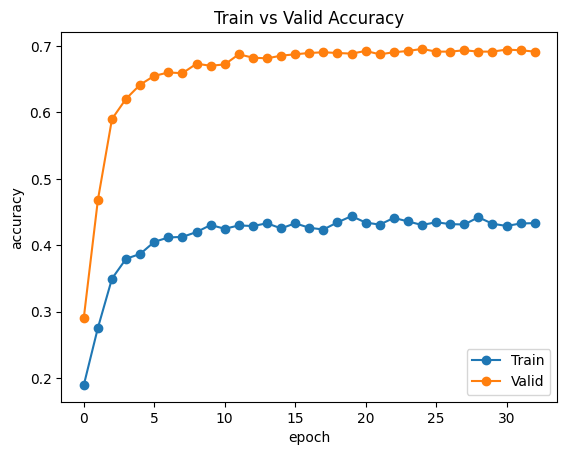

Text(0.5, 1.0, 'Train vs Valid Loss')

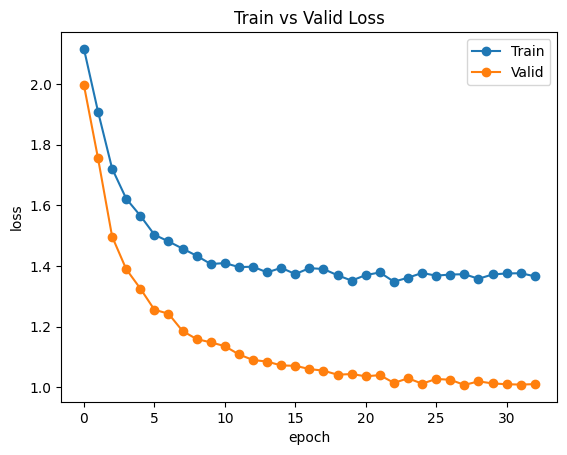

In [43]:

plt.plot(train_accs,'-o')
plt.plot(val_accs,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()


plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')

# **TESTING**

In [ ]:
def test_model(model):
  model.to("cuda")
  test_loss = 0
  correct = 0
  total = 0
  print(len(test_loader))
  expected_classes = []
  predicted_classes = []
  model.eval()
  # Disable gradient computation for efficiency
  with torch.no_grad():
      # Iterate over the test dataset
      for data, target in test_loader:
          # Move the data to the specified device
          data, target = data.to(device), target.to(device)
          expected_classes.extend(target.int().tolist())
          # Forward pass
          output = model(data)

          # Compute the loss
          test_loss += F.cross_entropy(output, target, reduction='sum').item()

          # Compute the predicted classes
          _, predicted = torch.max(output.data, 1)

          predicted_classes.extend(predicted.int().tolist())
          # Update the accuracy
          total += target.size(0)
          correct += (predicted == target).sum().item()

  # Compute the average test loss and accuracy
  test_loss /= len(test_loader.dataset)
  test_acc = 100. * correct / total

  # Print the test results
  # print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_acc))

  # Return the test loss and accuracy
  return test_loss, test_acc, expected_classes,predicted_classes

test_losses, test_accs,expected_classes, predicted_classes = test_model(model)




6


## **TEST with F1 Score:**

In [ ]:
predicted_tensor = torch.Tensor(predicted_classes)
expected_tensor = torch.Tensor(expected_classes)
#F1 Score
print(f"F1 Score: {multiclass_f1_score(predicted_tensor, expected_tensor, num_classes=9)}")


F1 Score: 0.6432836055755615


## **TEST with Recall Metric**

In [ ]:
metric = MulticlassRecall(num_classes=9, average='weighted')
print(f"Recall metric: {metric(predicted_tensor, expected_tensor)}")

Recall metric: 0.6432836055755615


In [ ]:
model.to("cpu")

In [ ]:

# Switch the model to eval model
model.eval()

# An example input you would normally provide to your model's forward() method.
example = torch.rand(1, 3, 224, 224)
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example)

# Save the TorchScript model
traced_script_module.save('drive/MyDrive/MyShroomClassifier/Models/traced_model_resnet34_a4_6194_with_adagrad.pt')